<center>
    <h1>
        Image Processing and Computer Vision
    </h1>
    <h2>
        Fruit inspection
    </h2>
</center>

<br>

<b>Student</b>: Matteo Donati <br>
<b>Registration no.</b>: 1032227 <br>
<b>E-mail</b>: matteo.donati10@studio.unibo.it

<br>

<hr>

### Libraries

The main libraries are imported.

In [1]:
# Importing cv2.
import cv2

# Importing numpy.
import numpy as np

# Importing pyplot.
from matplotlib import pyplot as plt

# Using TeX to render text.
plt.rc("text", usetex = True)

# Setting the pyplot font family.
plt.rc("font", family = "serif")

# Setting the pyplot font size.
plt.rcParams.update({"font.size": 15})

### First Task: Fruit Segmentation and Defect Detection

The aim of the first task is to correctly segment the fruit out of the given images, and then to detect the external defects of each fruit. To do so, the following steps have been taken:

1. **Image segmentation**:

    1. The gray-level histogram of each image has been computed and then analyzed.
    2. Based on the result obtained at step 1, a suitable thresholding method has been chosen.
    3. A flood-fill method has been used to fill the defect blobs of each image.
    4. Finally, the computed binary mask have finally been applied to the given images.
    
    
2. **Search for the defects in each fruit**:

    1. Starting from the images obtained at step 1.D, a suitable edge detector has been used in order to find the edges of the different images.
    2. Given such edge masks, the original images have been modified so that external defects are finally highlighted.

First of all, the given images are loaded and plotted.

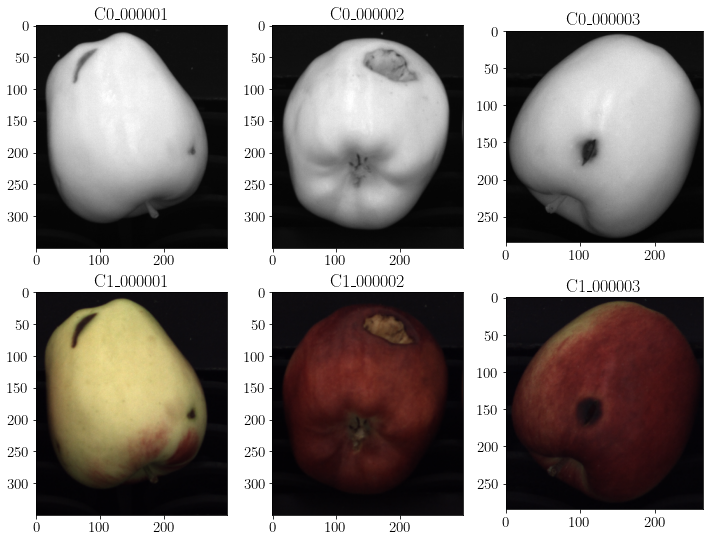

In [34]:
# Defining the filenames of gray-scale images.
gray_scale_filenames = ["C0\_000001", "C0\_000002", "C0\_000003"]

# Defining the filenames of colour images.
colour_filenames = ["C1\_000001", "C1\_000002", "C1\_000003"]

# Computing the number of images.
N_images = len(gray_scale_filenames)

# Defining the list containing gray-scale images.
gray_scale_images = []

# Defining the list containing colour images.
colour_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (12, 9))

# Reading the gray-scale images.
for i in range(N_images):
    
    # Reading the specific images.
    gray_scale_images.append(cv2.imread("images/first_task/{}.png".format(gray_scale_filenames[i].replace("\\", "")), cv2.IMREAD_GRAYSCALE))
    
    # Reading the specific images.
    colour_images.append(cv2.imread("images/first_task/{}.png".format(colour_filenames[i].replace("\\", ""))))
    
    # Converting the red image into RGB.
    colour_images[i] = cv2.cvtColor(colour_images[i], cv2.COLOR_BGR2RGB)
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(gray_scale_images[i], cmap = "gray", vmin = 0, vmax = 255)
    ax[1, i].imshow(colour_images[i])

# Showing the figure.
plt.show()

The gray-scale images, `C0_000001`, `C0_000002`, and `C0_000003`, have been filtered using a bilateral filter which allows one to de-noise the orignial images by preserving fruits edges. In particular, such filter uses a $7 \times 7$ neighbourhood, a spatial standard deviation $\sigma_s = 3$, and an intensity standard deviation $\sigma_s = 10$. Then, starting from such filtered images, the gray-scale histograms have been produced.

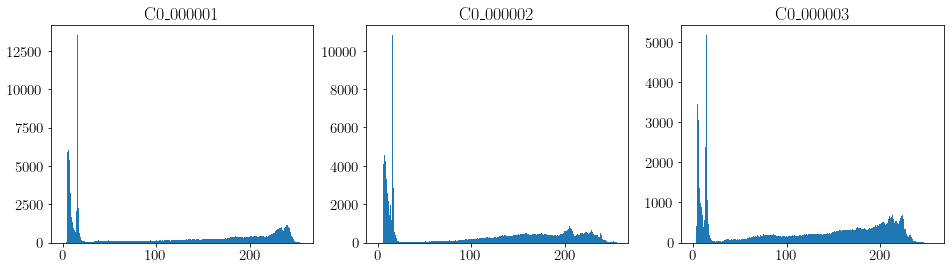

In [35]:
# List of the filtered gray-scale images.
f_gray_scale_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (16, 4))

# Filtering the images.
for i in range(N_images):
    
    # Appending the filtered image.
    f_gray_scale_images.append(cv2.bilateralFilter(gray_scale_images[i], d = 7, sigmaColor = 10, sigmaSpace = 3))
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Adding the histogram of the smoothed image to the figure.
    ax[i].hist(f_gray_scale_images[i].flatten(), bins = range(256))

# Showing the figure.
plt.show()

Looking at the produced histograms, it is not trivial to determine a precise threshold which allows one to perfectly binarize the images, especially for the `C0_000003` image. For this reason, the Otsu's thresholding method has been used. Such method allows one to minimize the *within-group variance*, $\sigma^2_W$, or equivalently to maximize the *between-group variance*, $\sigma^2_B$. In particular, minimizing $\sigma^2_W$ means finding a suitable threshold $t$ such that the sum of the variances of the two disjoint regions, the background and the foreground, is minimized (i.e. the two regions are as much homogeneous as possible). Equivalently, maximizing $\sigma^2_B$ means finding a suitable threshold $t$ such that background and foreground are as much separated as possible.

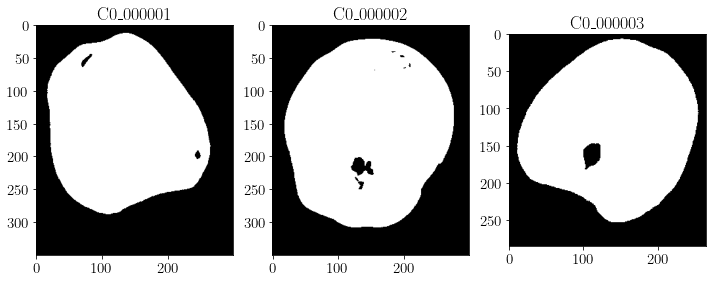

In [20]:
# List of masks.
threshold_masks = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Thesholding the gray-scale images.
for i in range(N_images):
    
    # Applying Otsu's thresholding (https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html).
    threshold_value, binary_mask = cv2.threshold(f_gray_scale_images[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Appending the generated binary mask.
    threshold_masks.append(binary_mask)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(threshold_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

The computed masks show some holes due to the external defects of the fruits. To fill these holes, the `floodFill` function of OpenCV has been used.

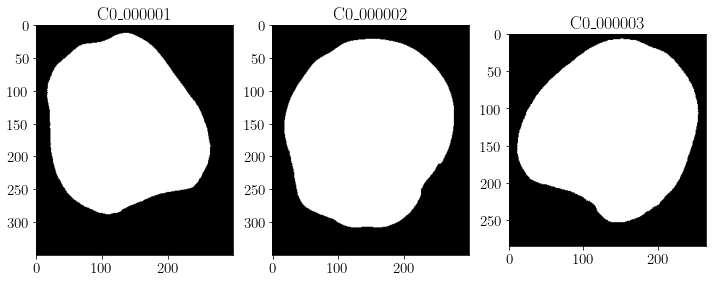

In [21]:
# List of masks.
fruit_masks = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Filling the holes of the already computed masks (https://learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/).
for i in range(N_images):
    
    # Copying masks[i].
    mask_copy = threshold_masks[i].copy()
    
    # Filling the holes inside the mask.
    cv2.floodFill(mask_copy, None, (0, 0), 255)
    
    # Inverting the flood-filled image.
    inv = cv2.bitwise_not(mask_copy)
    
    # Adding the final mask by or-ing masks[i] and inv.
    fruit_masks.append(threshold_masks[i] | inv)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

The final fruits masks are stored in the defined `fruit_masks` list. In particular, these masks will be used to segment the original images so that the chosen edge detector would not find any spurious edge in the background of the given images.

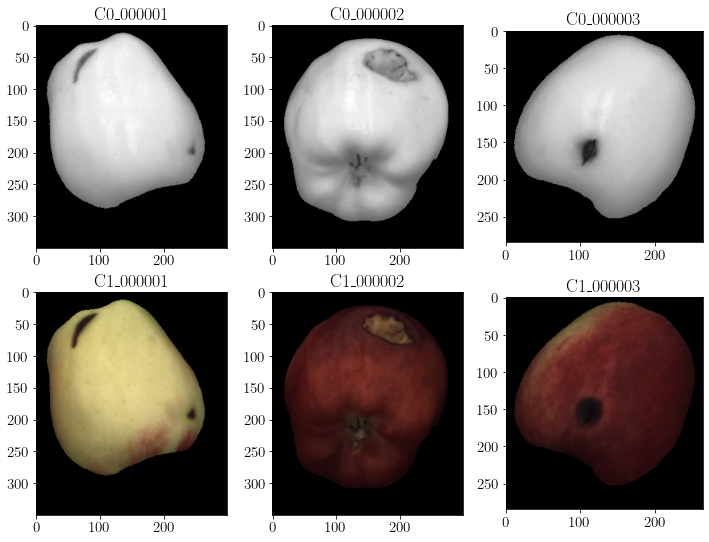

In [22]:
# List of masked gray-scale images.
m_gray_scale_images = []

# List of masked colour images.
m_colour_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (12, 9))

# Applying the computed final masks to the original images.
for i in range(N_images):
    
    # Applying the computed mask to the specific gray-scale image.
    m_gray_scale_images.append(gray_scale_images[i] & fruit_masks[i])
    
    # Applying the computed mask to the specific colour image.
    m_colour_images.append(colour_images[i] & cv2.cvtColor(fruit_masks[i], cv2.COLOR_GRAY2BGR))
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(m_gray_scale_images[i], cmap = "gray", vmin = 0, vmax = 255)
    ax[1, i].imshow(m_colour_images[i])

# Showing the figure.
plt.show()

Once all the original images have been segmented, the chosen edge detector is used in order to detect the sharp edges of fruits. To do so, the Canny's edge detector is used. In particular such edge detector takes in input two different thresholds, $t_l$ and $t_h$, which respectively define the two thresholds used by the hysteresis function to filter out spurious edges. In this particular case, $t_l = 75$, while $t_h = 200$.

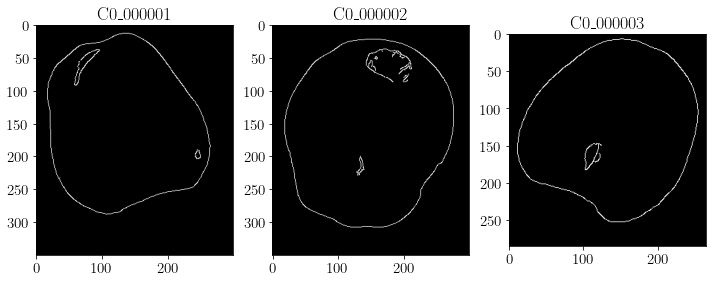

In [23]:
# List of masks.
edges = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Applying Canny Edge Detector to every segmented image.
for i in range(N_images):
    
    # Applying Canny Edge Detector to the specific image. In particular, the thresholds (75, 200) are used.
    edges.append(cv2.Canny(m_gray_scale_images[i], 75, 200))
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(edges[i], cmap = "gray")
    
# Showing the plot.
plt.show()

Once the edges have been computed, the resulting edge list not only contains information about fruits defects, but also information related to fruits borders, which are not interesting and would lead to detect false positive defects. In order to remove fruits borders, the erosion operator is used. In particular, such operator works by using a specific structuring element, similar to a convolutional kernel, which allows one to erode away the boundaries of the foreground object. Moreover, the portions of input image to erode are selected thanks to the specific structuring element. In this specific case, an elliptical $5 \times 5$ structuring element has been chosen.

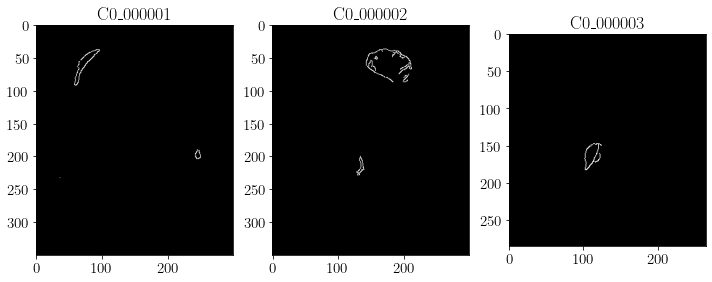

In [24]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Applying erosion in order to preserve only fruit damages.
for i in range(N_images):
    
    # Computing the eroded mask.
    eroded_mask = cv2.erode(fruit_masks[i], cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations = 1)
    
    # Updating edges[i].
    fruit_masks[i] = edges[i] * eroded_mask
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")
    
# Showing the plot.
plt.show()

Finally, the computed edge masks are used to highlight the external defects of each fruit. To do so, the original images' pixels which correspond to the defects' borders have been coloured in red.

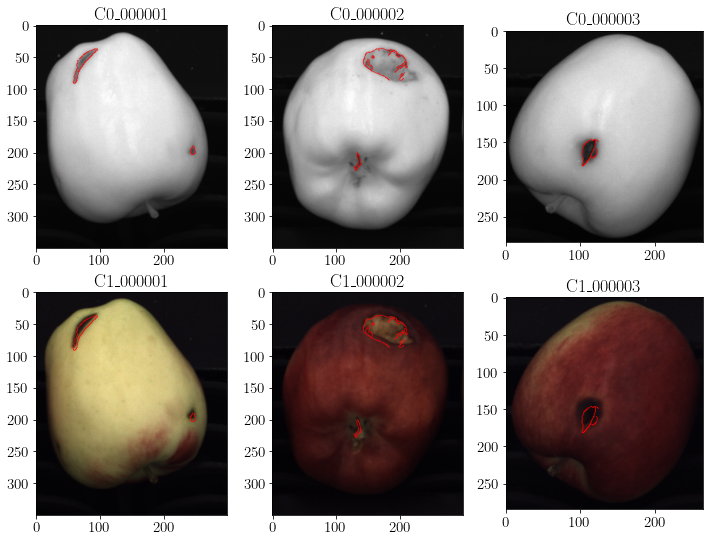

In [25]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (12, 9))

# Applying the computed edges masks to the original images.
for i in range(N_images):
    
    # Converting the specific gray-scale image to RGB.
    img_g = cv2.cvtColor(gray_scale_images[i], cv2.COLOR_GRAY2BGR)
    
    # Copying the specific colour image.
    img_c = colour_images[i].copy()
    
    # Iterating over the rows of the image.
    for j in range(img_g.shape[0]):
        
        # Iterating over the columns of the image.
        for k in range(img_g.shape[1]):
            
            # Checking the value of the mask.
            if(fruit_masks[i][j, k]):
                
                # Colouring images.
                img_g[j, k] = [255, 0, 0]
                img_c[j, k] = [255, 0, 0]
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(img_g)
    ax[1, i].imshow(img_c)

# Showing the figure.
plt.show()

### Second Task: Russet Detection

The aim of the second task is to correctly detect the russet area in each fruit. To do so, the following steps have been taken:

1. **Image segmentation**:

    1. The gray-level histogram of each image has been computed and then analyzed.
    2. Based on the result obtained at step 1, a suitable thresholding method has been chosen.
    3. Finally, the computed binary masks have been applied to the given images.
    
    
2. **Search for the russet area in each fruit**:

    1. Starting from the images obtained at step 1.C, four different colour spaces have been considered (RGB, HSV, HLS, LUV).
    2. A suitable colour distance has been used in order to segment the images and detect the russet area.
    3. Given the russet masks, the original images have been modified so that russet areas are finally highlighted.

First of all, the given images are loaded and plotted.

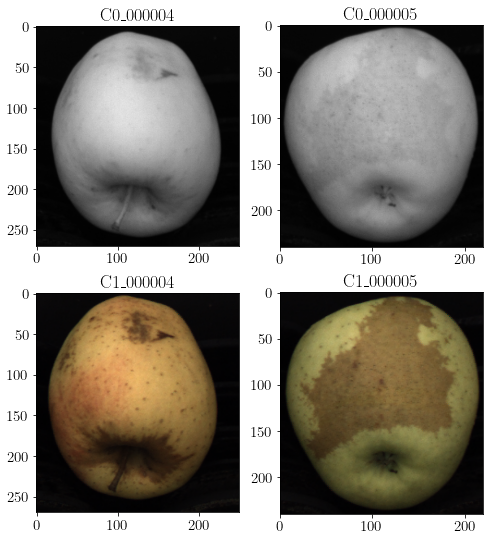

In [22]:
# Defining the filenames of gray-scale images.
gray_scale_filenames = ["C0\_000004", "C0\_000005"]

# Defining the filenames of colour images.
colour_filenames = ["C1\_000004", "C1\_000005"]

# Computing the number of images.
N_images = len(gray_scale_filenames)

# Defining the list containing gray-scale images.
gray_scale_images = []

# Defining the list containing colour images.
colour_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (8, 9))

# Reading the gray-scale images.
for i in range(N_images):
    
    # Reading the specific images.
    gray_scale_images.append(cv2.imread("images/second_task/{}.png".format(gray_scale_filenames[i].replace("\\", "")), cv2.IMREAD_GRAYSCALE))
    
    # Reading the specific images.
    colour_images.append(cv2.imread("images/second_task/{}.png".format(colour_filenames[i].replace("\\", ""))))
    
    # Converting the red image into RGB.
    colour_images[i] = cv2.cvtColor(colour_images[i], cv2.COLOR_BGR2RGB)
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(gray_scale_images[i], cmap = "gray", vmin = 0, vmax = 255)
    ax[1, i].imshow(colour_images[i])

# Showing the figure.
plt.show()

The gray-scale images, `C0_000004`, and `C0_000005`, have been filtered using a bilateral filter which allows one to de-noise the original images by preserving fruits edges.

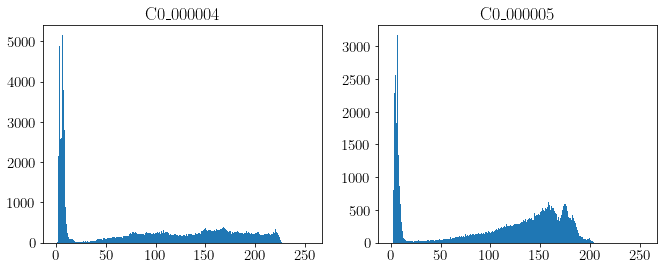

In [23]:
# List of the filtered gray-scale images.
f_gray_scale_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (11, 4))

# Filtering the images.
for i in range(N_images):
    
    # Appending the filtered image.
    f_gray_scale_images.append(cv2.bilateralFilter(gray_scale_images[i], d = 7, sigmaColor = 10, sigmaSpace = 3))
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Adding the histogram of the smoothed image to the figure.
    ax[i].hist(f_gray_scale_images[i].flatten(), bins = range(256))

# Showing the figure.
plt.show()

In order to compute fruits' masks, a global threshold, $t = 25$, has been chosen.

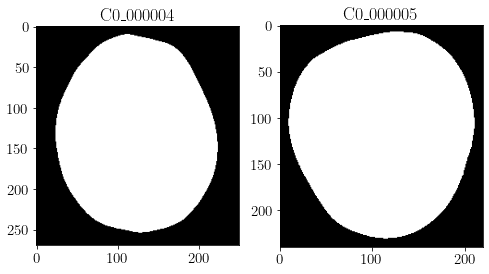

In [24]:
# List of masks.
fruit_masks = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (8, 5))

# Thesholding the gray-scale images.
for i in range(N_images):
    
    # Applying Otsu's thresholding (https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html).
    threshold_value, binary_mask = cv2.threshold(f_gray_scale_images[i], 25, 255, cv2.THRESH_BINARY)
    
    # Definition of an erosion kernel.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    
    # Erosion of the binary mask.
    binary_mask = cv2.erode(binary_mask, kernel, iterations = 1)
    
    # Appending the generated binary mask.
    fruit_masks.append(binary_mask)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

The original images have then been masked, using the already computed binary masks, and converted into the corresponding HSV, HLS, LUV images.

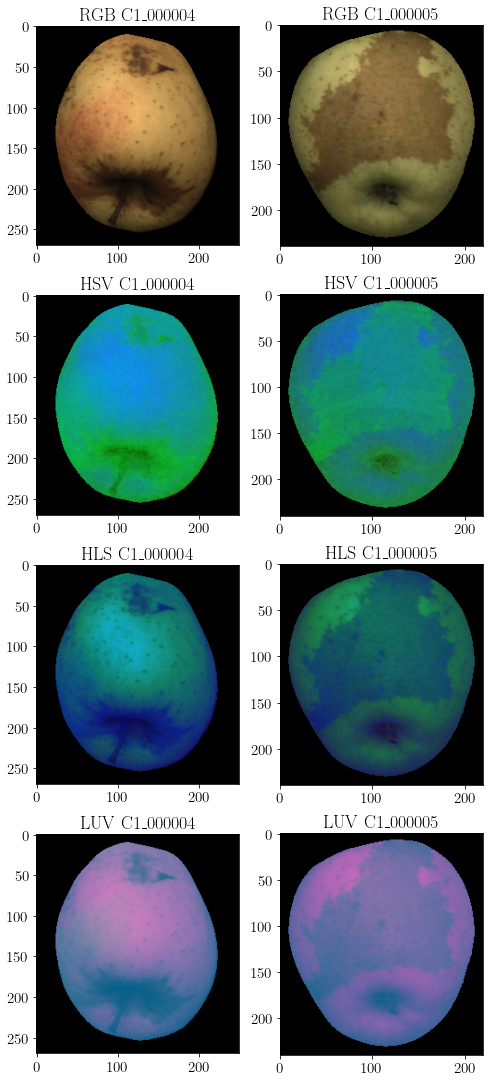

In [25]:
# Colour space dictionary.
spaces = {"RGB": 0, "HSV": 1, "HLS": 2, "LUV": 3}

# List of flags used to convert the specific images.
flags = [None, cv2.COLOR_RGB2HSV, cv2.COLOR_RGB2HLS, cv2.COLOR_RGB2LUV]

# List of masked images.
m_images = [[] for i in range(len(spaces))]

# Defining the figure object to be displayed.
fig, ax = plt.subplots(len(spaces), N_images, figsize = (8, 19))

# Iterating over images.
for i in range(N_images):
    
    # Temporary image used for masking each m_images element.
    tmp = cv2.cvtColor(fruit_masks[i], cv2.COLOR_GRAY2RGB)
    
    # Iterating over colour spaces.
    for key, value in spaces.items():
        
        # Checking the value of key.
        if key == "RGB":
            
            # Applying the computed mask to the specific colour image.
            m_images[value].append(colour_images[i] & tmp)
            
        # Checking the value of key.
        else:
            
            # Applying the computed mask to the specific colour image.
            m_images[value].append(cv2.cvtColor(colour_images[i], flags[value]) & tmp)
            
        # Adding the specific titles.
        ax[value, i].set_title(key + " " + colour_filenames[i])

        # Plotting the computed images.
        ax[value, i].imshow(m_images[value][i])

# Showing the figure.
plt.show()

In order to detect the russet areas, the Mahalanobis distance has been used. in particular, to distinguish between russet areas and non-russet areas, a suitable colour reference has to be found for each of the considered colour spaces. Such reference has been computed, by only considering specific regions of interest, as follows:

$$
mean^{i, j, k} = \frac{1}{NZP^i} \sum_{m = 0}^{N^i} images^{i, j, k}_m
$$

where:

- $N^i$ is the total number of pixels of the $i$-th image.
- $NZP^i$ is the number of non-zero pixels of the $i$-th image.
- $i \in [0, 1]$ is the image index ($0$ for `C0_000004`, $1$ for `C0_000005`).
- $j \in [0, 1, 2]$ is the channel index.
- $k \in [0, 1, 2, 3]$ is the colour space index ($0$ for RGB, $1$ for HSV, $2$ for HLS, $3$ for LUV).

In order to produce the final colour reference, $\boldsymbol{\mu}$ (namely, the `ref` list), the mean between $mean^{0, j, k}$ and $mean^{1, j, k}$ has been computed for each $j \in [0, 1, 2]$ and $k \in [0, 1, 2, 3]$.

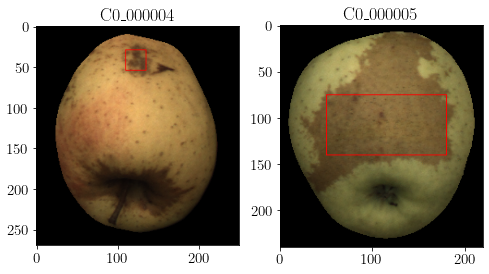

In [26]:
# Defining the ROIs starting points.
start_point = [[110, 30], [50, 75]]

# Defining the ROIs ending points.
end_point = [[135, 55], [180, 140]]

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (8, 5))

# Thesholding the gray-scale images.
for i in range(N_images):
    
    # Copyint the RGB image.
    img = np.copy(m_images[0][i])
    
    # Drawing the rectangle defining the specific ROI.
    img = cv2.rectangle(img, start_point[i], end_point[i], (255, 0, 0), 1)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(img, cmap = "gray")

# Showing the figure.
plt.show()

Now that the regions of interest have been identified, the reference colour $\boldsymbol{\mu}$ can be computed.

In [30]:
# List of mean values.
mean_values = [[] for i in range(len(spaces))]

# List of reference values.
ref = []

# Iterating over colour spaces.
for key, value in spaces.items():

    # Iterating over images.
    for i in range(N_images):
        
        # Computing the mean values by considering the ROIs.
        mean_values[value].append(np.mean(m_images[value][i][start_point[i][0]:end_point[i][0], 
                                                             start_point[i][1]:end_point[i][1]], axis = (0, 1)))

    # Computing the mean of mean_values on axis zero.    
    ref.append(np.mean(mean_values[value], axis = 0))

Given such colour references, the Mahalanobis distance of each pixel, of both images, in each considered colour space, has then been computed. Such distance is computed as follows:

$$
d(\boldsymbol{I}(p), \boldsymbol{\mu}) = ((\boldsymbol{I}(p) - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{I}(p) - \boldsymbol{\mu}))^{1/2}
$$

where:

- $\boldsymbol{I}(p) = [I_0(p), I_1(p), I_2(p)]^T$ is the vector containing the intensities of the three channels at pixel $p$.
- $\boldsymbol{\mu} = [\mu_0(p), \mu_1(p), \mu_2(p)]^T$ is the vector containing the reference values of the three channels.
- $\Sigma$ is the covariance matrix defined as follows:

$$
\Sigma =
\begin{bmatrix}
\sigma^2_{00} & \sigma^2_{01} & \sigma^2_{02} \\
\sigma^2_{10} & \sigma^2_{11} & \sigma^2_{12} \\
\sigma^2_{20} & \sigma^2_{21} & \sigma^2_{22}
\end{bmatrix},
\quad
\sigma^2_{i, j} = \frac{1}{N} \sum_{k = 1}^N (I_i(p) - \mu_i) (I_j(p) - \mu_j)
$$

where:

- $N$ is the total number of pixels of the considered image.
- $i, j \in [0, 1, 2]$ are the channel indexes.

In [31]:
# Defining the list containing the inverse of the covariance matrices.
inv_covs = [[] for i in range(len(spaces))]

# Defining the list containing the Mahalanobis distances.
distances = [[] for i in range(len(spaces))]

# Shapes list.
shapes = []

# Iterating over images.
for i in range(N_images):
    
    # Computing the shapes of the original images.
    shapes.append(colour_images[i].shape)
    
    # Iterating over colour spaces.
    for key, value in spaces.items():
        
        # Flattening the images.
        m_images[value][i] = m_images[value][i].reshape((shapes[i][0] * shapes[i][1], shapes[i][2]))
        
        # Computing the inverse of the covariance matrix for the specific image.
        inv_covs[value].append(np.linalg.inv(np.cov(m_images[value][i].T)))
        
        # Temporary distance list.
        distance = [[] for i in range(len(spaces))]
        
        # Iterating over the rows of the specific image.
        for j in range(shapes[i][0] * shapes[i][1]):

            # Appending the Mahalanobis value to the specific distance list.
            distance[value].append(np.sqrt(np.dot(np.dot((m_images[value][i][j] - ref[value]).T, inv_covs[value][i]), (m_images[value][i][j] - ref[value]))))
            
        # Appending the computed distance list to the distances list.
        distances[value].append(distance[value])

Finally, once the distances have been computed, a suitable threshold, $t$, has to be found in order to distinguish between russet areas and non-russet areas. In particular:

$$
\forall p \in image^{i, j}:
\begin{cases}
p_{russet} & \text{if } d^{i, j}_p \leq t^{i, j} \\
p_{non\text{-}russet} & \text{otherwise}
\end{cases}
$$

Such threshold has been set equal to the following quantity:

$$
t^{i, j} = \frac{1}{1.5 \cdot N} \sum_{p = 0}^N d^{i, j}_k
$$

where:

- $i \in [0, 1]$ is the image index ($0$ for `C0_000004`, $1$ for `C0_000005`).
- $j \in [0, 1, 2, 3]$ is the colour space index ($0$ for RGB, $1$ for HSV, $2$ for HLS, $3$ for LUV).
- $d^{i, j}_p$ is the Mahalanobis distance computed for pixel $p$, in the $i$-th image, for the $j$-th colour space.

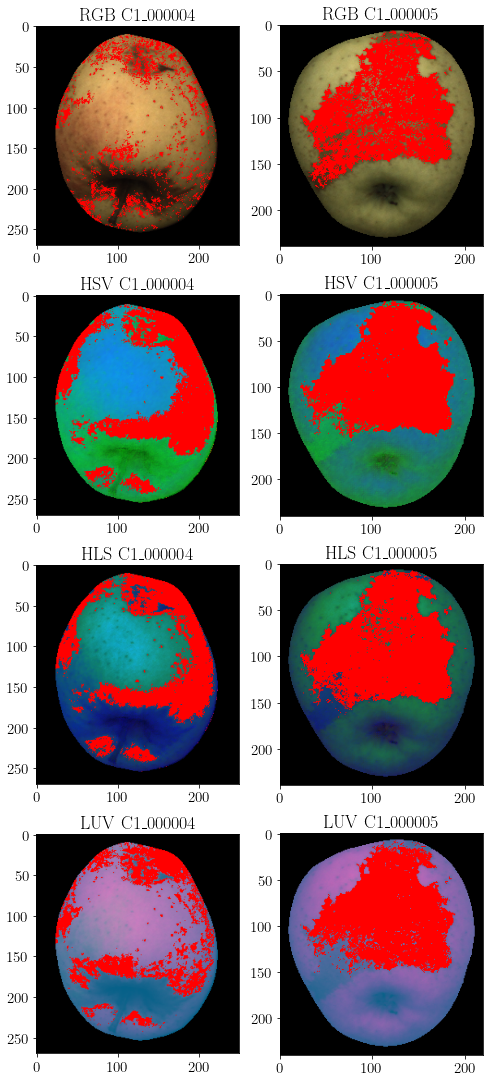

In [32]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(4, N_images, figsize = (8, 19))

# Iterating over images.
for i in range(N_images):
    
    # Defining the list containing the mean values of distances.
    mean_dist = []
    
    # Defining the list containing the copies of images.
    copies = []
    
    # Iterating over colour spaces.
    for key, value in spaces.items():
        
        # Computing the mean of distances.
        mean_dist.append(np.mean(distances[value][i]))
        
        # Reshaping the images.
        m_images[value][i] = m_images[value][i].reshape((shapes[i][0], shapes[i][1], shapes[i][2]))
        
        # Creating copies of the images.
        copies.append(np.copy(m_images[value][i]))
        
        # Reshaping the computed distances.
        distances[value][i] = np.array(distances[value][i]).reshape((shapes[i][0], shapes[i][1]))
        
        # Iterating over the rows of the image.
        for j in range(shapes[i][0]):

            # Iterating over the columns of the image.
            for k in range(shapes[i][1]):

                # Checking if fruit_masks[i] == 255.
                if fruit_masks[i][j, k] == 255:

                    # Checking if the distance is lower than mean_X / 1.5.
                    if distances[value][i][j][k] <= mean_dist[value] / 1.5:
                        
                        # Colouring the image.
                        copies[value][j, k, :] = [255, 0, 0]
        
        # Adding the specific titles.
        ax[value, i].set_title(key + " " + colour_filenames[i])

        # Plotting the computed images.
        ax[value, i].imshow(copies[value])
    
# Showing the figure.
plt.show()

However, the computed `C0_000004` images show a very high number of false-posivites (i.e. pixels which have been marked as russet pixels, but which are non-russet pixels). In order to obtain better results, the three channels of the RGB images have been considered.

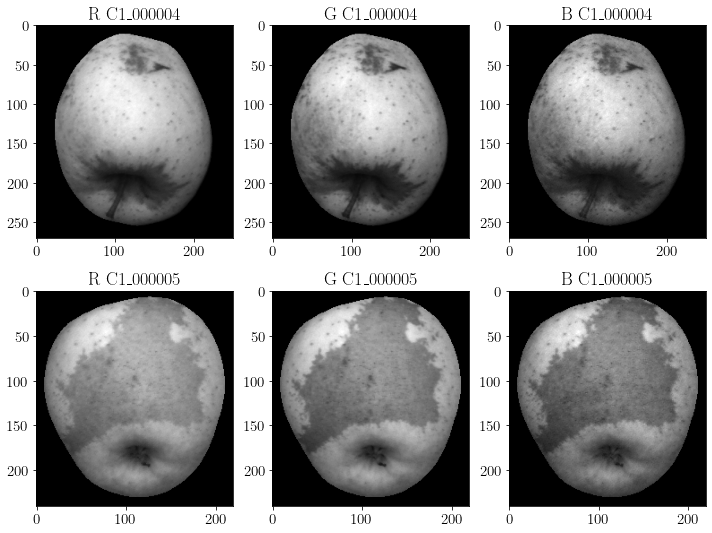

In [110]:
# List of channels' names.
channels_names = ["R", "G", "B"]

# Defining the figure object to be displayed.
fig, ax = plt.subplots(N_images, len(channels_names), figsize = (12, 9))

# Iterating over channels.
for i in range(len(channels_names)):
    
    # Adding the specific titles.
    ax[0, i].set_title(channels_names[i] + " " + colour_filenames[0])
    ax[1, i].set_title(channels_names[i] + " " + colour_filenames[1])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(m_images[spaces["RGB"]][0][:, :, i], cmap = "gray")
    ax[1, i].imshow(m_images[spaces["RGB"]][1][:, :, i], cmap = "gray")

# Showing the figure.
plt.show()

From such images, it is possible to notice that the in the blue colour the russet areas of the fruits are much darker from the non-russet areas. Given this, a suitable threshold has been applied in order to try to separate russet areas from non-russet areas. In particular, the adaptive thresholding algorithm, using a block-size of $75$ (`blockSize = 75`, in the `cv2.adaptiveThreshold` function call) has yielded the best possible result.

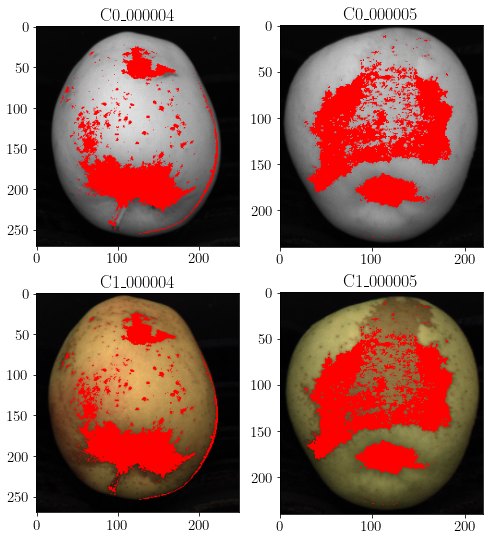

In [111]:
# Best channels is B for both images.
best_channel_index = 2

# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (8, 9))

# Iterating over images.
for i in range(N_images):
    
    # Converting the specific gray-scale image to RGB.
    img_g = cv2.cvtColor(gray_scale_images[i], cv2.COLOR_GRAY2BGR)
    
    # Copying the specific colour image.
    img_c = colour_images[i].copy()
    
    # Applying adaptive thresholding.
    binary_mask = cv2.adaptiveThreshold(m_images[spaces["RGB"]][i][:, :, best_channel_index], 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 75, 0)
    
    # Iterating over the rows of the image.
    for j in range(img_g.shape[0]):
        
        # Iterating over the columns of the image.
        for k in range(img_g.shape[1]):
            
            # Checking the value of the mask.
            if fruit_masks[i][j, k] == 255 and binary_mask[j, k] == 255:
                
                # Colouring the images.
                img_g[j, k, :] = [255, 0, 0]
                img_c[j, k, :] = [255, 0, 0]
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(img_g)
    ax[1, i].imshow(img_c)

# Showing the figure.
plt.show()

The computed russet areas show a number of false positives which is less than the number of false posivites found when using the afore-mentioned colour-based segmentation method.

### Final Challenge: Kiwi Inspection

The aim of the second task is to correctly detect the defect area in image `C0_000007`. To do so, the following steps have been taken:

1. **Image segmentation**:

    1. The gray-level histogram of each image has been computed and then analyzed.
    2. Based on the result obtained at step 1, a suitable thresholding method has been chosen.
    3. The computed binary masks have been modified in order to eliminate the dirt located on the conveyor, as well as the sticker in image `C0_000006`.
    4. Finally, the computed binary masks have been applied to the given images.
    
    
2. **Search for the defect area**:

    1. Starting from the images obtained at step 1.D, suitable masks have been computed so to detect defect areas in all the given images. The only defect such masks have to detect is the one in the afore-mentioned image (`C0_000007`).
    2. Given such binary masks, the original images have been modified so that the defect area is highlighted.

First of all, the given images are loaded and plotted.

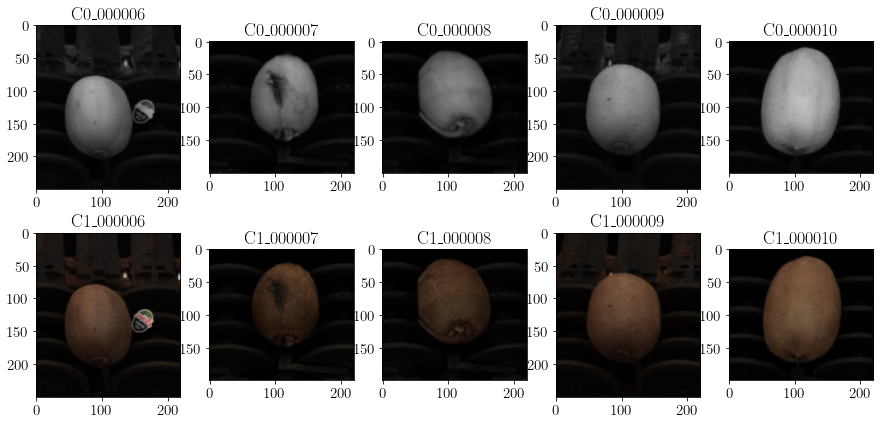

In [28]:
# Defining the filenames of gray-scale images.
gray_scale_filenames = ["C0\_000006", "C0\_000007", "C0\_000008", "C0\_000009", "C0\_000010"]

# Defining the filenames of colour images.
colour_filenames = ["C1\_000006", "C1\_000007", "C1\_000008", "C1\_000009", "C1\_000010"]

# Computing the number of images.
N_images = len(gray_scale_filenames)

# Defining the list containing gray-scale images.
gray_scale_images = []

# Defining the list containing colour images.
colour_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (15, 7))

# Reading the gray-scale images.
for i in range(N_images):
    
    # Reading the specific images.
    gray_scale_images.append(cv2.imread("images/final_challenge/{}.png".format(gray_scale_filenames[i].replace("\\", "")), cv2.IMREAD_GRAYSCALE))
    
    # Reading the specific images.
    colour_images.append(cv2.imread("images/final_challenge/{}.png".format(colour_filenames[i].replace("\\", ""))))
    
    # Converting the red image into RGB.
    colour_images[i] = cv2.cvtColor(colour_images[i], cv2.COLOR_BGR2RGB)
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(gray_scale_images[i], cmap = "gray", vmin = 0, vmax = 255)
    ax[1, i].imshow(colour_images[i])

# Showing the figure.
plt.show()

The gray-scale images have been filtered using a bilateral filter which allows one to de-noise the original images by preserving edges.

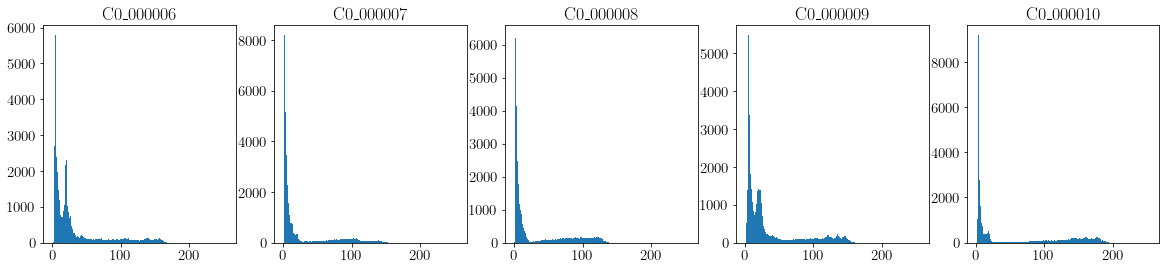

In [29]:
# List of the filtered gray-scale images.
f_gray_scale_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (20, 4))

# Filtering the images.
for i in range(N_images):
    
    # Appending the filtered image.
    f_gray_scale_images.append(cv2.bilateralFilter(gray_scale_images[i], d = 7, sigmaColor = 10, sigmaSpace = 3))
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Adding the histogram of the smoothed image to the figure.
    ax[i].hist(f_gray_scale_images[i].flatten(), bins = range(256))

# Showing the figure.
plt.show()

In order to compute fruits' masks, a global threshold, $t = 50$, has been chosen.

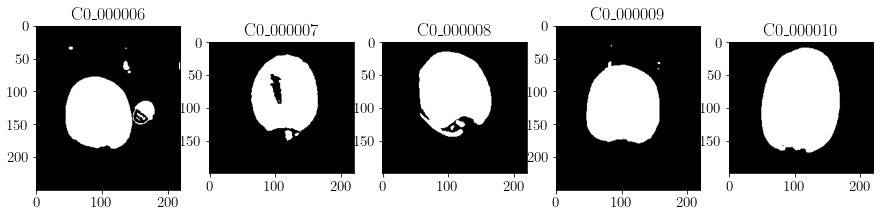

In [30]:
# List of masks.
fruit_masks = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (15, 4))

# Thesholding the gray-scale images.
for i in range(N_images):
    
    # Applying global thresholding.
    threshold_value, binary_mask = cv2.threshold(f_gray_scale_images[i], 50, 255, cv2.THRESH_BINARY)
    
    # Appending the generated binary mask.
    fruit_masks.append(binary_mask)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

In order to remove the dirt located on the conveyor, as well as the sticker in image `C0_000006`, the following has been applied:

1. The opening operator has been applied. In particular, a $22 \times 22$ elliptic structuring element has been used in order to remove noise (the dirt of the conveyor and the sticker).
2. The dilation operator has been applied. In particular, a $5 \times 5$ elliptic structuring element has been used in order to increase the size of the foreground fruits.

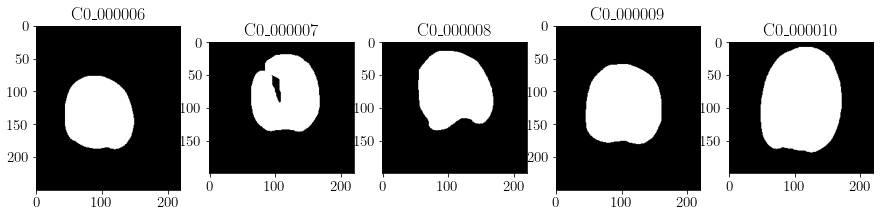

In [31]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (15, 4))

# Iterating over images.
for i in range(N_images):  
    
    # Defining the opening kernel.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (22, 22))
    
    # Applying opening.
    fruit_masks[i] = cv2.morphologyEx(fruit_masks[i], cv2.MORPH_OPEN, kernel)
    
    # Defining the dilation kernel.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Applying dilation.
    fruit_masks[i] = cv2.dilate(fruit_masks[i], kernel, iterations = 1)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")
    
# Showing the plot.
plt.show()

Starting from these binary masks, in order to correctly detect defects in image `C0_000007`, a flood-fill technique followed by a bitwise-not operator have been used.

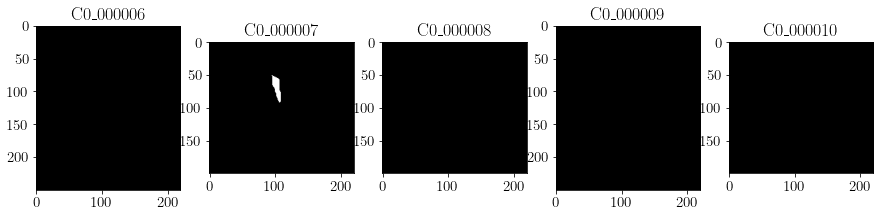

In [32]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (15, 4))

# Iterating over images.
for i in range(N_images):
    
    # Filling everything except for the defect.
    cv2.floodFill(fruit_masks[i], None, (0, 0), 255)

    # Inverting the mask.
    fruit_masks[i] = cv2.bitwise_not(fruit_masks[i])
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")
    
# Showing the plot.
plt.show()    

Finally, the computed defects masks are used to highlight the external defects of each fruit. To do so, the original images' pixels which correspond to defects' pixels have been coloured in red. In particular, the only defect such masks have to detect is the one in image `C0_000007`.

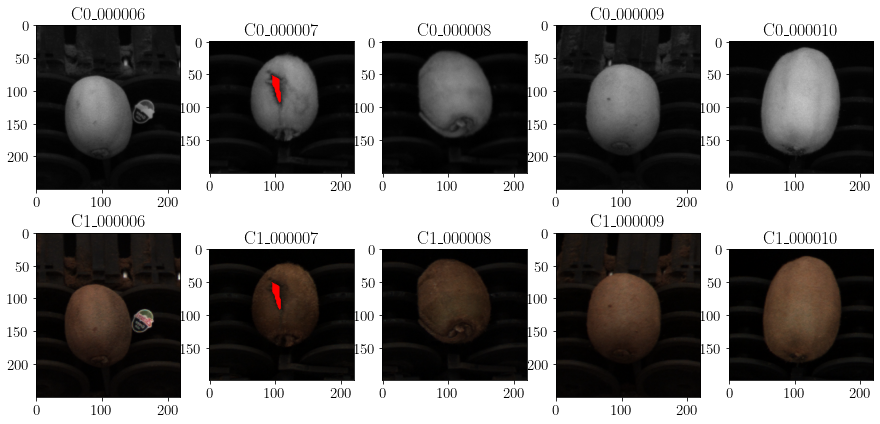

In [33]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (15, 7))

# Reading the gray-scale images.
for i in range(N_images):
    
    # Converting the specific gray-scale image to RGB.
    img_g = cv2.cvtColor(gray_scale_images[i], cv2.COLOR_GRAY2BGR)
    
    # Copying the specific colour image.
    img_c = colour_images[i].copy()
    
    # Iterating over the rows of the image.
    for j in range(img_g.shape[0]):
        
        # Iterating over the columns of the image.
        for k in range(img_g.shape[1]):
            
            # Checking the value of the mask.
            if fruit_masks[i][j, k] == 255: 
                
                # Colouring the images.
                img_g[j, k, :] = [255, 0, 0]
                img_c[j, k, :] = [255, 0, 0]
    
    # Adding the specific titles.
    ax[0, i].set_title(gray_scale_filenames[i])
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(img_g, cmap = "gray")
    ax[1, i].imshow(img_c)

# Showing the figure.
plt.show()